![Lab Logo](https://www.smu.tn/storage/app/media/logos/medtechlogo-b.png)                                                               

<span style="color:darkblue; font-weight:bold; font-size:32px; font-family:Montserrat;">CS434 Lab 4: Feature Engineering & Regression Models
</span><br>
<span style="color:black; font-size:16px; font-family:Montserrat;">Fatma Alzahra Mohamed, SE-G1</span>

# Data Loading and Exploration

In [11]:

# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
data = pd.read_csv('/kaggle/input/housing-prices-dataset/Housing.csv')

# Display basic information
print("Dataset Shape:", data.shape)
print("\n" + "="*50)
print("First Few Rows:")
print("="*50)
print(data.head())

print("\n" + "="*50)
print("Dataset Information:")
print("="*50)
print(data.info())

print("\n" + "="*50)
print("Statistical Summary:")
print("="*50)
print(data.describe())

print("\n" + "="*50)
print("Missing Values:")
print("="*50)
missing = data.isnull().sum()
print(missing[missing > 0])

print("\n" + "="*50)
print("Data Types:")
print("="*50)
print(data.dtypes)

Dataset Shape: (545, 13)

First Few Rows:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

Dataset Information:
<class 'pandas.core.frame.DataFrame

# Exploratory Data Analysis and Visualization

Numerical Columns: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

Categorical Columns: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


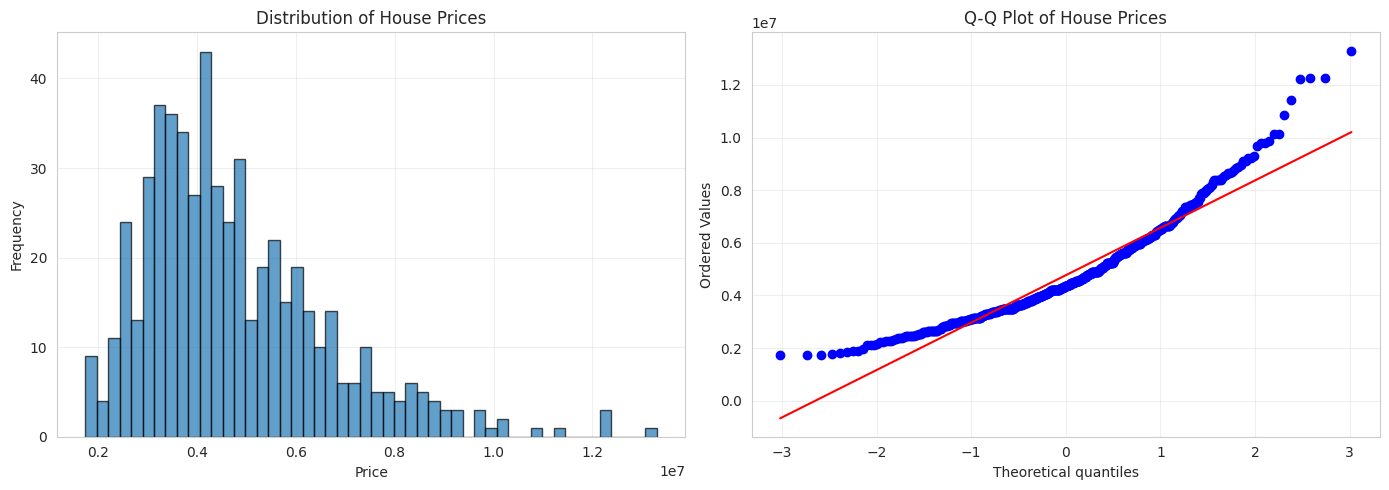


Skewness of price: 1.2122
Kurtosis of price: 1.9601


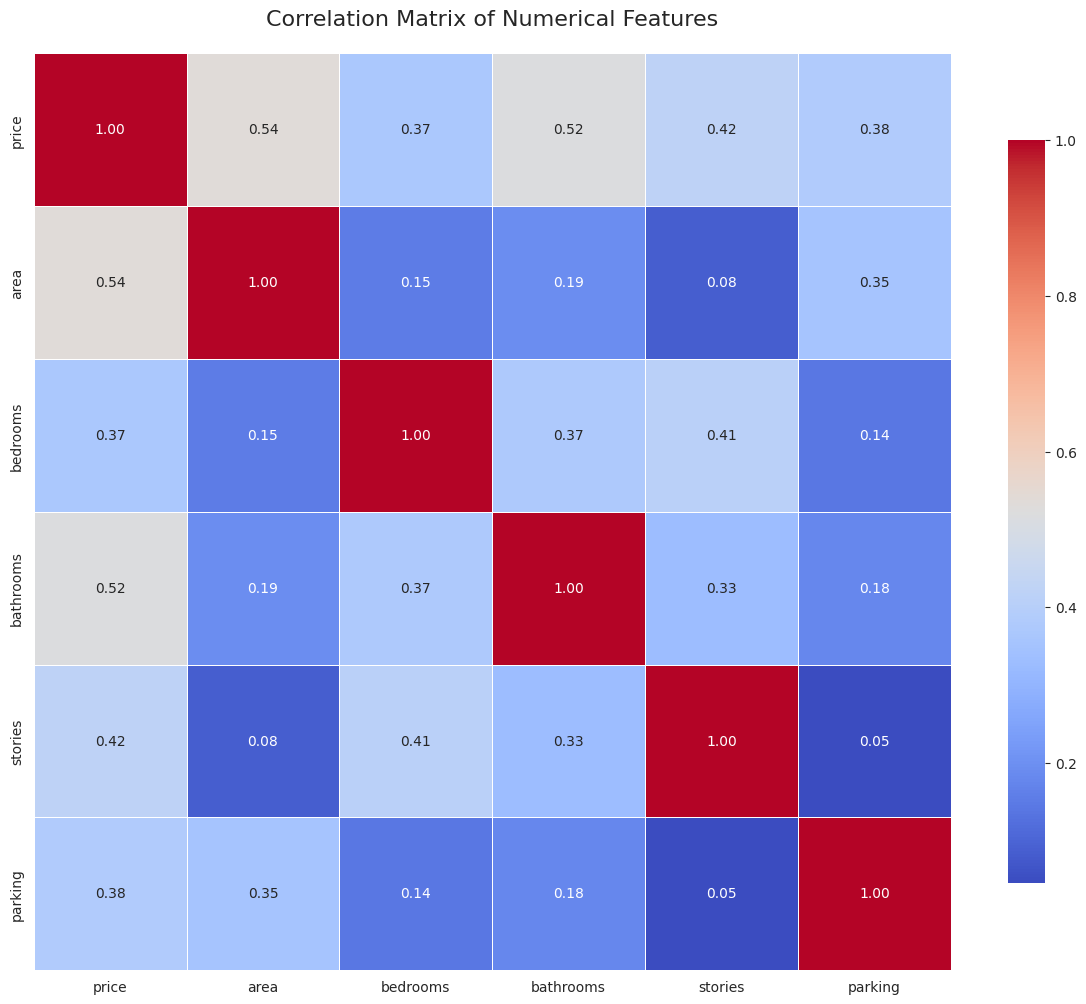


Top Features Correlated with Price:
area         0.535997
bathrooms    0.517545
stories      0.420712
parking      0.384394
bedrooms     0.366494
Name: price, dtype: float64


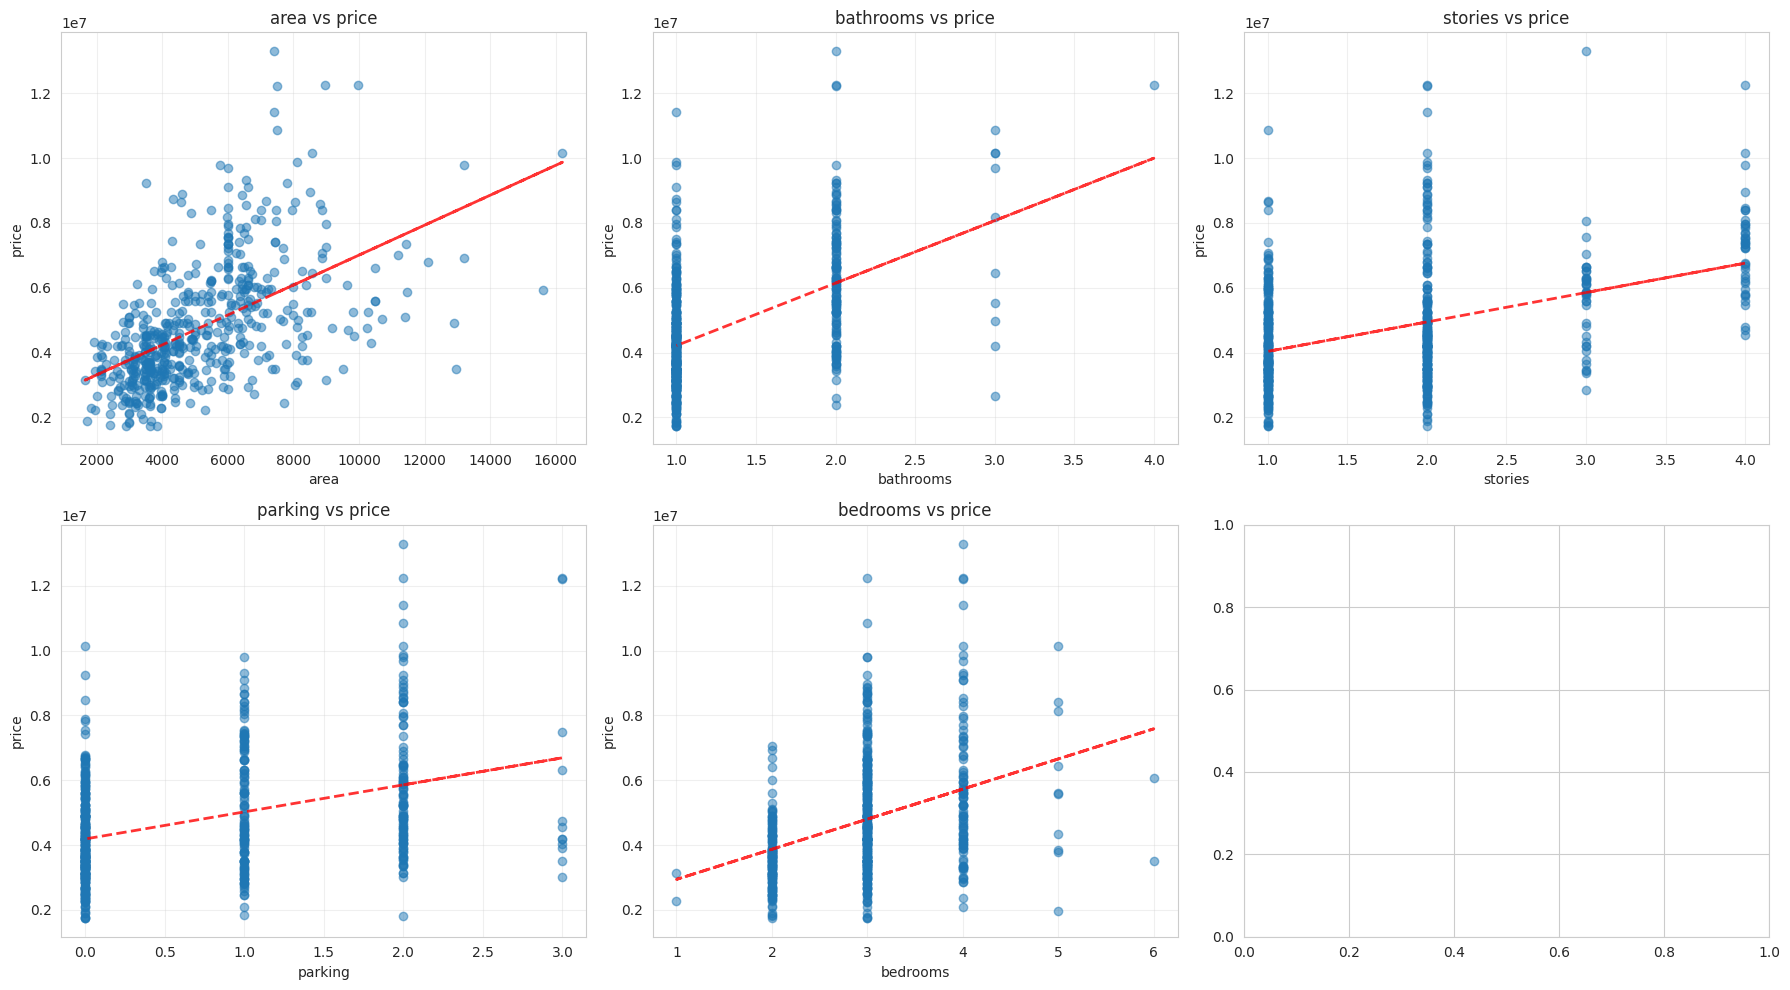

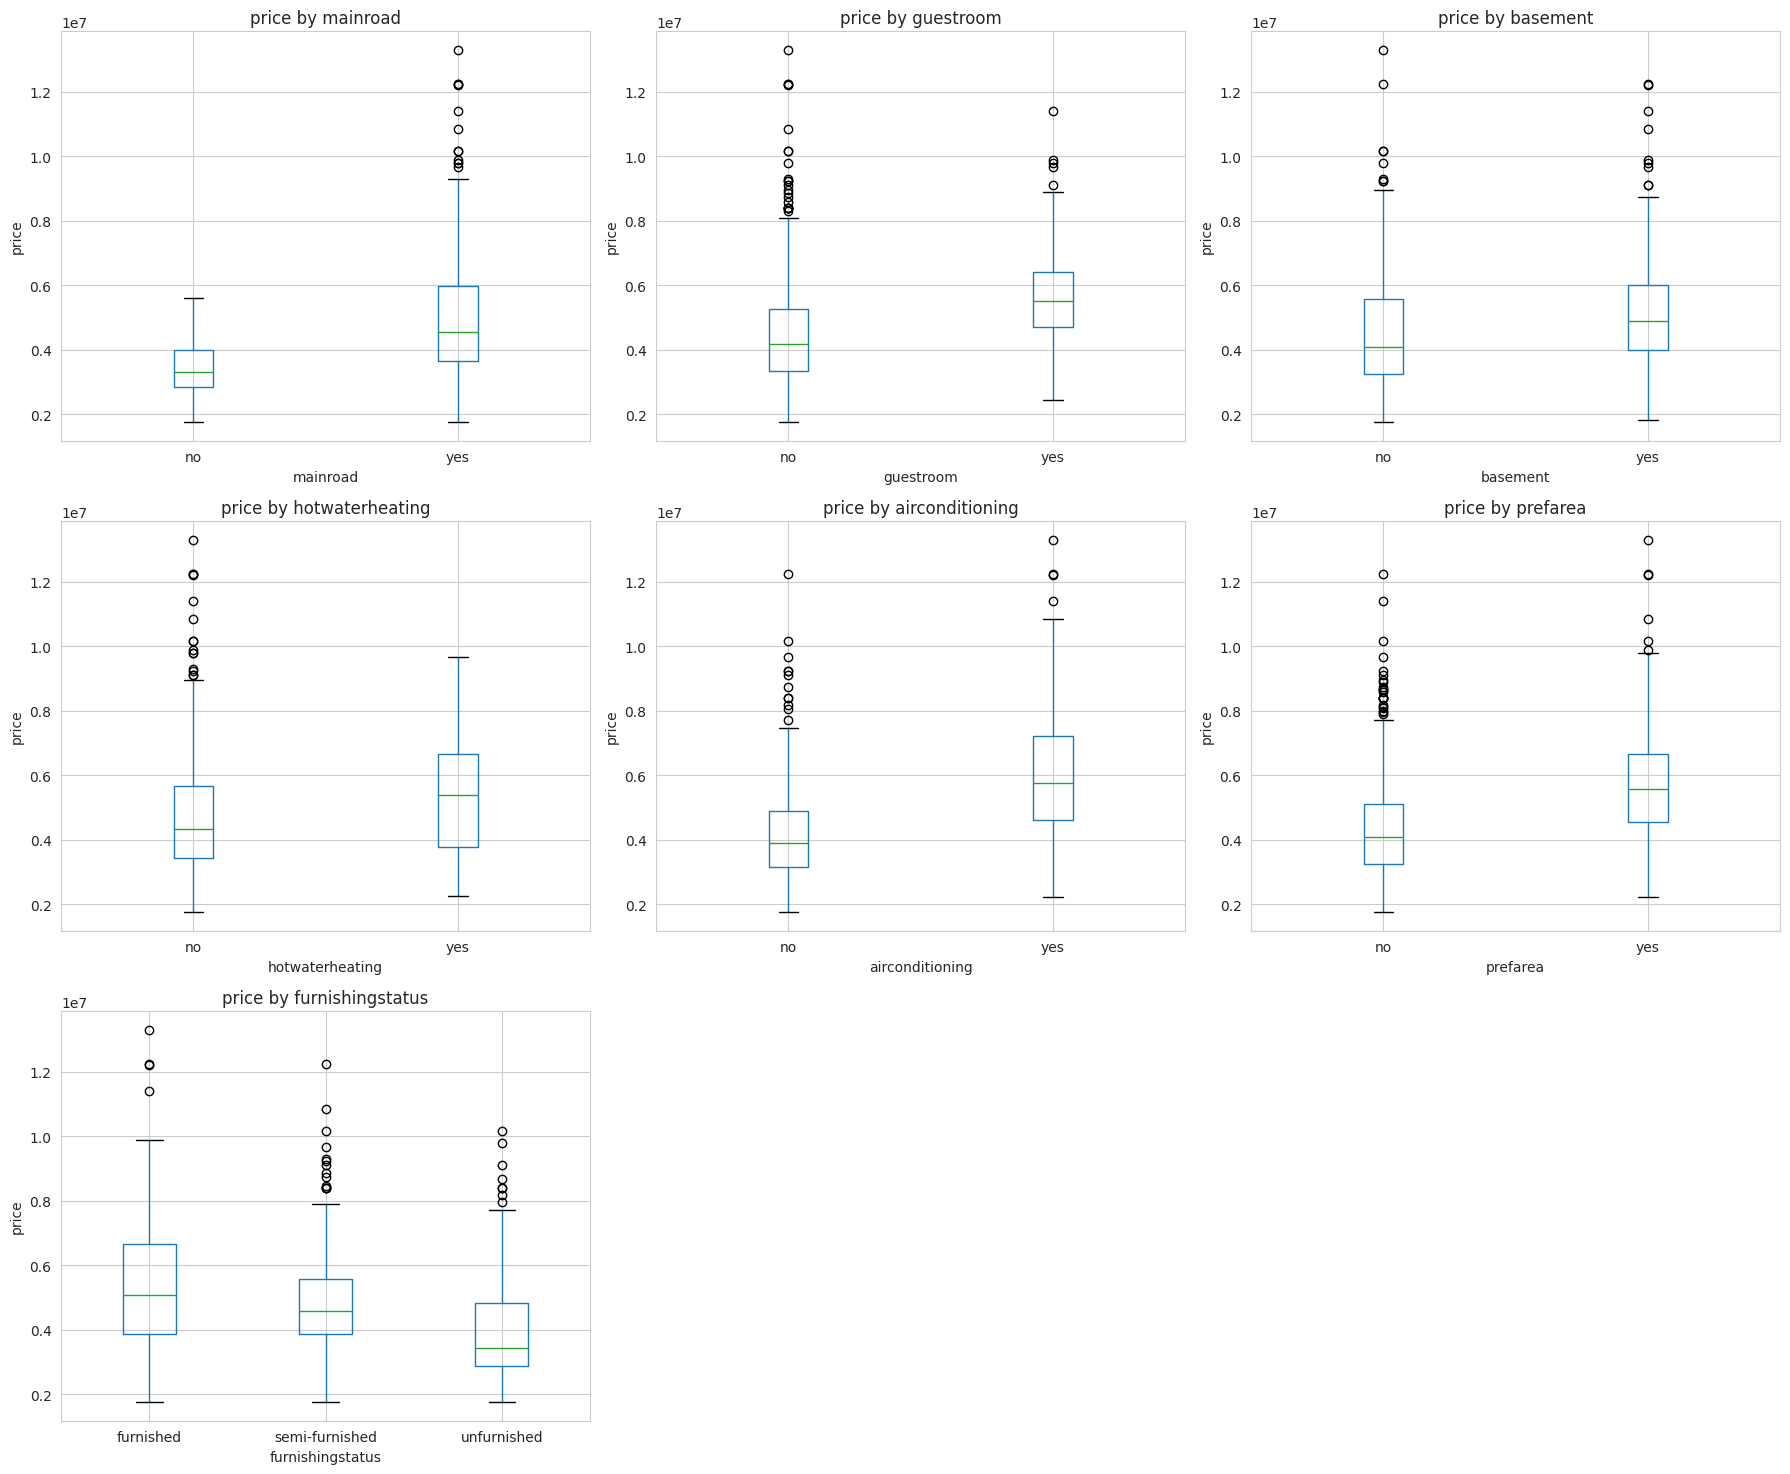


Outlier Detection (IQR Method):
area: 12 outliers detected (2.20%)
bedrooms: 12 outliers detected (2.20%)
bathrooms: 1 outliers detected (0.18%)
stories: 41 outliers detected (7.52%)
parking: 12 outliers detected (2.20%)


In [12]:

# Separate numerical and categorical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("\nCategorical Columns:", categorical_cols)


target_col = 'price'

# Distribution of Target Variable
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(data[target_col], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
stats.probplot(data[target_col], dist="norm", plot=plt)
plt.title('Q-Q Plot of House Prices')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check skewness of target variable
print(f"\nSkewness of {target_col}: {data[target_col].skew():.4f}")
print(f"Kurtosis of {target_col}: {data[target_col].kurtosis():.4f}")

# Correlation Analysis
plt.figure(figsize=(12, 10))
correlation_matrix = data[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Top correlations with target variable
target_corr = correlation_matrix[target_col].abs().sort_values(ascending=False)
print("\n" + "="*50)
print("Top Features Correlated with Price:")
print("="*50)
print(target_corr[1:])  # Exclude the target itself

# Visualize relationship between top features and target
top_features = target_corr[1:6].index.tolist()  # Top 5 features

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(top_features):
    axes[idx].scatter(data[col], data[target_col], alpha=0.5)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel(target_col)
    axes[idx].set_title(f'{col} vs {target_col}')
    axes[idx].grid(True, alpha=0.3)
    
    # Add regression line
    z = np.polyfit(data[col], data[target_col], 1)
    p = np.poly1d(z)
    axes[idx].plot(data[col], p(data[col]), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

# Box plots for categorical variables
if len(categorical_cols) > 0:
    n_cat = len(categorical_cols)
    fig, axes = plt.subplots((n_cat + 2) // 3, 3, figsize=(18, 5 * ((n_cat + 2) // 3)))
    axes = axes.ravel() if n_cat > 1 else [axes]
    
    for idx, col in enumerate(categorical_cols):
        if idx < len(axes):
            data.boxplot(column=target_col, by=col, ax=axes[idx])
            axes[idx].set_title(f'{target_col} by {col}')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel(target_col)
    
    # Hide unused subplots
    for idx in range(len(categorical_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('')  # Remove default title
    plt.tight_layout()
    plt.show()

# Outlier Detection using IQR method
print("\n" + "="*50)
print("Outlier Detection (IQR Method):")
print("="*50)

for col in numerical_cols:
    if col != target_col:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = data[(data[col] < Q1 - 1.5 * IQR) | (data[col] > Q3 + 1.5 * IQR)]
        if len(outliers) > 0:
            print(f"{col}: {len(outliers)} outliers detected ({len(outliers)/len(data)*100:.2f}%)")

# Data Preprocessing and Feature Engineering

Original dataset shape: (545, 13)

Step 1: Handling Missing Values
No missing values found!

Step 2: Outlier Treatment
Removed 13 extreme outliers
Dataset shape after outlier removal: (532, 13)

Step 3: Target Variable Transformation
Original skewness of price: 0.8651
Applied log transformation
New skewness: 0.0132


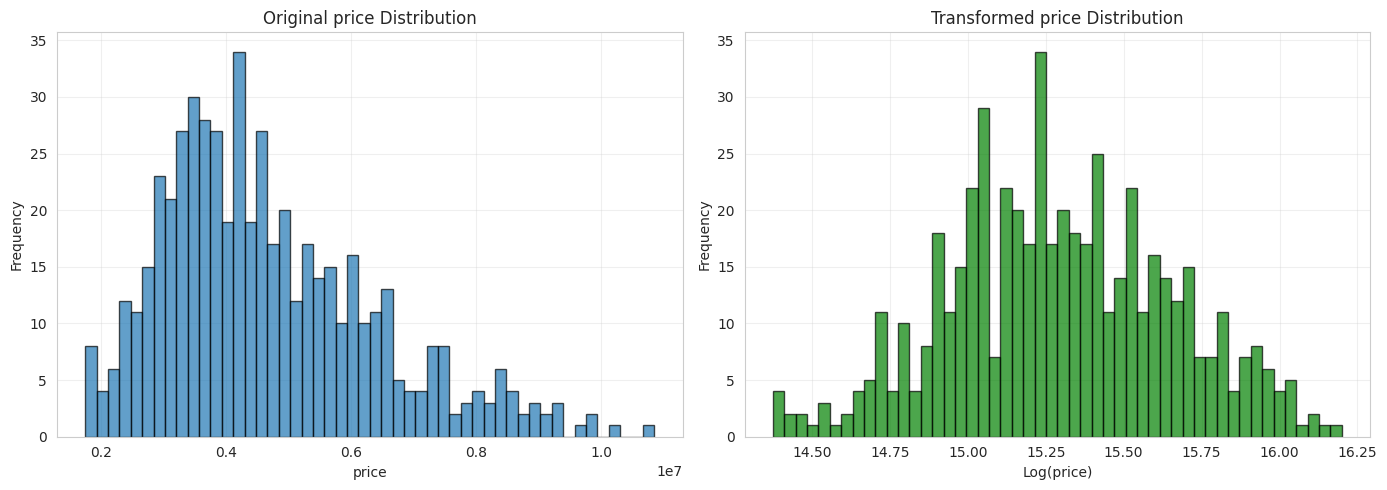


Step 4: Feature Transformation
Skewness of numerical features:
bathrooms    1.441100
stories      1.083215
area         0.867259
parking      0.863579
bedrooms     0.301694
dtype: float64

Applying Box-Cox transformation to 4 skewed features
Transformed bathrooms: new skewness = 1.3220
Transformed stories: new skewness = 0.4444
Transformed area: new skewness = -0.0046
Transformed parking: new skewness = 0.7192

Step 5: Encoding Categorical Variables
Encoding 7 categorical variables:
['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

Shape after encoding: (532, 15)

Step 6: Feature Scaling Preparation
Number of features: 13

Feature value ranges:
                min       max
area       7.409553  9.400887
bedrooms   1.000000  5.000000
bathrooms  0.788158  1.801833
stories    0.650085  1.389725
parking    0.000000  2.204717

Step 7: Feature Selection - Multicollinearity Check
No highly correlated features found

Final dataset sha

In [13]:
# Create a copy of the data for preprocessing
df = data.copy()

print("Original dataset shape:", df.shape)

# Step 1: Handle Missing Values
# ------------------------------
print("\n" + "="*50)
print("Step 1: Handling Missing Values")
print("="*50)

# Check for missing values
missing_counts = df.isnull().sum()
if missing_counts.sum() > 0:
    print("Missing values found:")
    print(missing_counts[missing_counts > 0])
    
    # For numerical columns: impute with median
    for col in numerical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
            print(f"Imputed {col} with median")
    
    # For categorical columns: impute with mode
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
            print(f"Imputed {col} with mode")
else:
    print("No missing values found!")

# Step 2: Outlier Treatment
# --------------------------
print("\n" + "="*50)
print("Step 2: Outlier Treatment")
print("="*50)

# Remove extreme outliers using Z-score method (keeping moderate outliers)
from scipy.stats import zscore

z_scores = np.abs(zscore(df[numerical_cols]))
threshold = 3.5  # More lenient threshold to preserve data
outlier_mask = (z_scores < threshold).all(axis=1)
df_clean = df[outlier_mask].copy()

print(f"Removed {len(df) - len(df_clean)} extreme outliers")
print(f"Dataset shape after outlier removal: {df_clean.shape}")

# Step 3: Target Variable Transformation
# ---------------------------------------
print("\n" + "="*50)
print("Step 3: Target Variable Transformation")
print("="*50)

# Check if target needs transformation (if skewed)
target_skewness = df_clean[target_col].skew()
print(f"Original skewness of {target_col}: {target_skewness:.4f}")

if abs(target_skewness) > 0.5:
    # Apply log transformation to reduce skewness
    df_clean['target_log'] = np.log1p(df_clean[target_col])
    print(f"Applied log transformation")
    print(f"New skewness: {df_clean['target_log'].skew():.4f}")
    target_transformed = 'target_log'
    
    # Visualize transformation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(df_clean[target_col], bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_title(f'Original {target_col} Distribution')
    axes[0].set_xlabel(target_col)
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(df_clean[target_transformed], bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[1].set_title(f'Transformed {target_col} Distribution')
    axes[1].set_xlabel(f'Log({target_col})')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    target_transformed = target_col
    print("Target variable is not significantly skewed. No transformation needed.")

# Step 4: Feature Transformation
# -------------------------------
print("\n" + "="*50)
print("Step 4: Feature Transformation")
print("="*50)

# Identify skewed numerical features (excluding target)
numerical_features = [col for col in numerical_cols if col != target_col]
skewed_features = df_clean[numerical_features].apply(lambda x: skew(x)).sort_values(ascending=False)

print("Skewness of numerical features:")
print(skewed_features)

# Apply Box-Cox transformation to highly skewed features
high_skew = skewed_features[abs(skewed_features) > 0.5]
print(f"\nApplying Box-Cox transformation to {len(high_skew)} skewed features")

for feat in high_skew.index:
    # Box-Cox requires positive values, so we add 1
    df_clean[feat] = boxcox1p(df_clean[feat], boxcox_normmax(df_clean[feat] + 1))
    print(f"Transformed {feat}: new skewness = {df_clean[feat].skew():.4f}")

# Step 5: Encoding Categorical Variables
# ---------------------------------------
print("\n" + "="*50)
print("Step 5: Encoding Categorical Variables")
print("="*50)

if len(categorical_cols) > 0:
    print(f"Encoding {len(categorical_cols)} categorical variables:")
    print(categorical_cols)
    
    # Use one-hot encoding
    df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)
    print(f"\nShape after encoding: {df_encoded.shape}")
else:
    df_encoded = df_clean.copy()
    print("No categorical variables to encode")

# Step 6: Feature Scaling (will be done in pipeline, but check ranges)
# ---------------------------------------------------------------------
print("\n" + "="*50)
print("Step 6: Feature Scaling Preparation")
print("="*50)

# Check feature ranges
feature_cols = [col for col in df_encoded.columns if col not in [target_col, target_transformed]]
print(f"Number of features: {len(feature_cols)}")
print("\nFeature value ranges:")
print(df_encoded[feature_cols].describe().loc[['min', 'max']].T.head(10))

# Step 7: Feature Selection - Remove Multicollinearity
# -----------------------------------------------------
print("\n" + "="*50)
print("Step 7: Feature Selection - Multicollinearity Check")
print("="*50)

# Calculate correlation matrix for features
feature_corr = df_encoded[feature_cols].corr()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        if abs(feature_corr.iloc[i, j]) > 0.9:
            high_corr_pairs.append((feature_corr.columns[i], 
                                   feature_corr.columns[j], 
                                   feature_corr.iloc[i, j]))

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (|r| > 0.9):")
    for feat1, feat2, corr in high_corr_pairs[:10]:  # Show first 10
        print(f"  {feat1} <-> {feat2}: {corr:.4f}")
    
    # Remove one feature from each highly correlated pair
    features_to_drop = [pair[1] for pair in high_corr_pairs]
    features_to_drop = list(set(features_to_drop))  # Remove duplicates
    
    df_final = df_encoded.drop(columns=features_to_drop)
    print(f"\nRemoved {len(features_to_drop)} highly correlated features")
else:
    df_final = df_encoded.copy()
    print("No highly correlated features found")

print(f"\nFinal dataset shape: {df_final.shape}")

# Step 8: Create Feature Engineering 
# ----------------------------------------------------------------
print("\n" + "="*50)
print("Step 8: Feature Engineering - Creating Interaction Features")
print("="*50)

# Get top correlated features with target
final_feature_cols = [col for col in df_final.columns if col not in [target_col, target_transformed]]
target_correlations = df_final[final_feature_cols + [target_transformed]].corr()[target_transformed].abs().sort_values(ascending=False)
top_features = target_correlations[1:4].index.tolist()  # Top 3 features

print(f"Creating interaction features from top 3 correlated features:")
print(top_features)

# Create interaction features (multiplication of top features)
if len(top_features) >= 2:
    df_final[f'{top_features[0]}_x_{top_features[1]}'] = df_final[top_features[0]] * df_final[top_features[1]]
    print(f"Created: {top_features[0]}_x_{top_features[1]}")
    
if len(top_features) >= 3:
    df_final[f'{top_features[0]}_x_{top_features[2]}'] = df_final[top_features[0]] * df_final[top_features[2]]
    print(f"Created: {top_features[0]}_x_{top_features[2]}")
    
    df_final[f'{top_features[1]}_x_{top_features[2]}'] = df_final[top_features[1]] * df_final[top_features[2]]
    print(f"Created: {top_features[1]}_x_{top_features[2]}")

print(f"\nFinal preprocessed dataset shape: {df_final.shape}")

# Save preprocessing summary
print("\n" + "="*50)
print("PREPROCESSING SUMMARY")
print("="*50)
print(f"Original dataset size: {data.shape}")
print(f"After outlier removal: {df_clean.shape}")
print(f"After encoding: {df_encoded.shape}")
print(f"Final preprocessed dataset: {df_final.shape}")
print(f"Target variable: {target_transformed}")
print(f"Number of features: {len([col for col in df_final.columns if col not in [target_col, target_transformed]])}")

# Train-Test Split and Feature Scaling

In [26]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler


# Separate features and target
X = df_final.drop(columns=[target_col, target_transformed] if target_transformed != target_col else [target_col])
y = df_final[target_transformed]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Split the data into training and testing sets
# Using 80-20 split with stratification for better representation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Train-Test split ratio: {len(X_train)/len(X) * 100:.1f}% - {len(X_test)/len(X) * 100:.1f}%")

# Feature Scaling
# ---------------
print("\n" + "="*50)
print("Feature Scaling")
print("="*50)

# Use RobustScaler (better for data with outliers)
scaler = RobustScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better interpretability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Feature scaling completed using RobustScaler")
print("\nScaled feature statistics (training set):")
print(X_train_scaled.describe().loc[['mean', 'std', 'min', 'max']])

# Verify no data leakage
print("\n" + "="*50)
print("Data Preparation Complete!")
print("="*50)
print(f"Features prepared: {X_train_scaled.shape[1]}")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Testing samples: {X_test_scaled.shape[0]}")
print(f"Target variable: {target_transformed}")
print(f"Scaling method: RobustScaler")


Feature matrix shape: (532, 16)
Target variable shape: (532,)

Training set size: (425, 16)
Testing set size: (107, 16)
Train-Test split ratio: 79.9% - 20.1%

Feature Scaling
Feature scaling completed using RobustScaler

Scaled feature statistics (training set):
          area  bedrooms  bathrooms   stories   parking  mainroad_yes  \
mean  0.061240 -0.063529   0.145181 -0.296944  0.637296     -0.152941   
std   0.663944  0.722425   0.259060  0.685517  0.780580      0.360355   
min  -1.745296 -2.000000   0.000000 -1.000000  0.000000     -1.000000   
max   1.719642  2.000000   1.013675  1.156526  2.541754      0.000000   

      guestroom_yes  basement_yes  hotwaterheating_yes  airconditioning_yes  \
mean       0.176471      0.345882             0.044706             0.305882   
std        0.381669      0.476216             0.206901             0.461323   
min        0.000000      0.000000             0.000000             0.000000   
max        1.000000      1.000000             1.000000

# Model Building and Training - Linear Regression Models


Training models with 5-Fold Cross Validation...

Training: Linear Regression
--------------------------------------------------
  Train RMSE: 0.1965 | Test RMSE: 0.2110
  Train R²: 0.6751 | Test R²: 0.7291
  CV RMSE: 0.2042 ± 0.0531
  Training time: 0.039s

Training: Ridge (α=0.1)
--------------------------------------------------
  Train RMSE: 0.1966 | Test RMSE: 0.2106
  Train R²: 0.6749 | Test R²: 0.7303
  CV RMSE: 0.2039 ± 0.0529
  Training time: 0.027s

Training: Ridge (α=1.0)
--------------------------------------------------
  Train RMSE: 0.1966 | Test RMSE: 0.2108
  Train R²: 0.6748 | Test R²: 0.7297
  CV RMSE: 0.2036 ± 0.0523
  Training time: 0.029s

Training: Ridge (α=10.0)
--------------------------------------------------
  Train RMSE: 0.1971 | Test RMSE: 0.2144
  Train R²: 0.6733 | Test R²: 0.7203
  CV RMSE: 0.2029 ± 0.0515
  Training time: 0.027s

Training: Lasso (α=0.0001)
--------------------------------------------------
  Train RMSE: 0.1966 | Test RMSE: 0.2105
  Trai

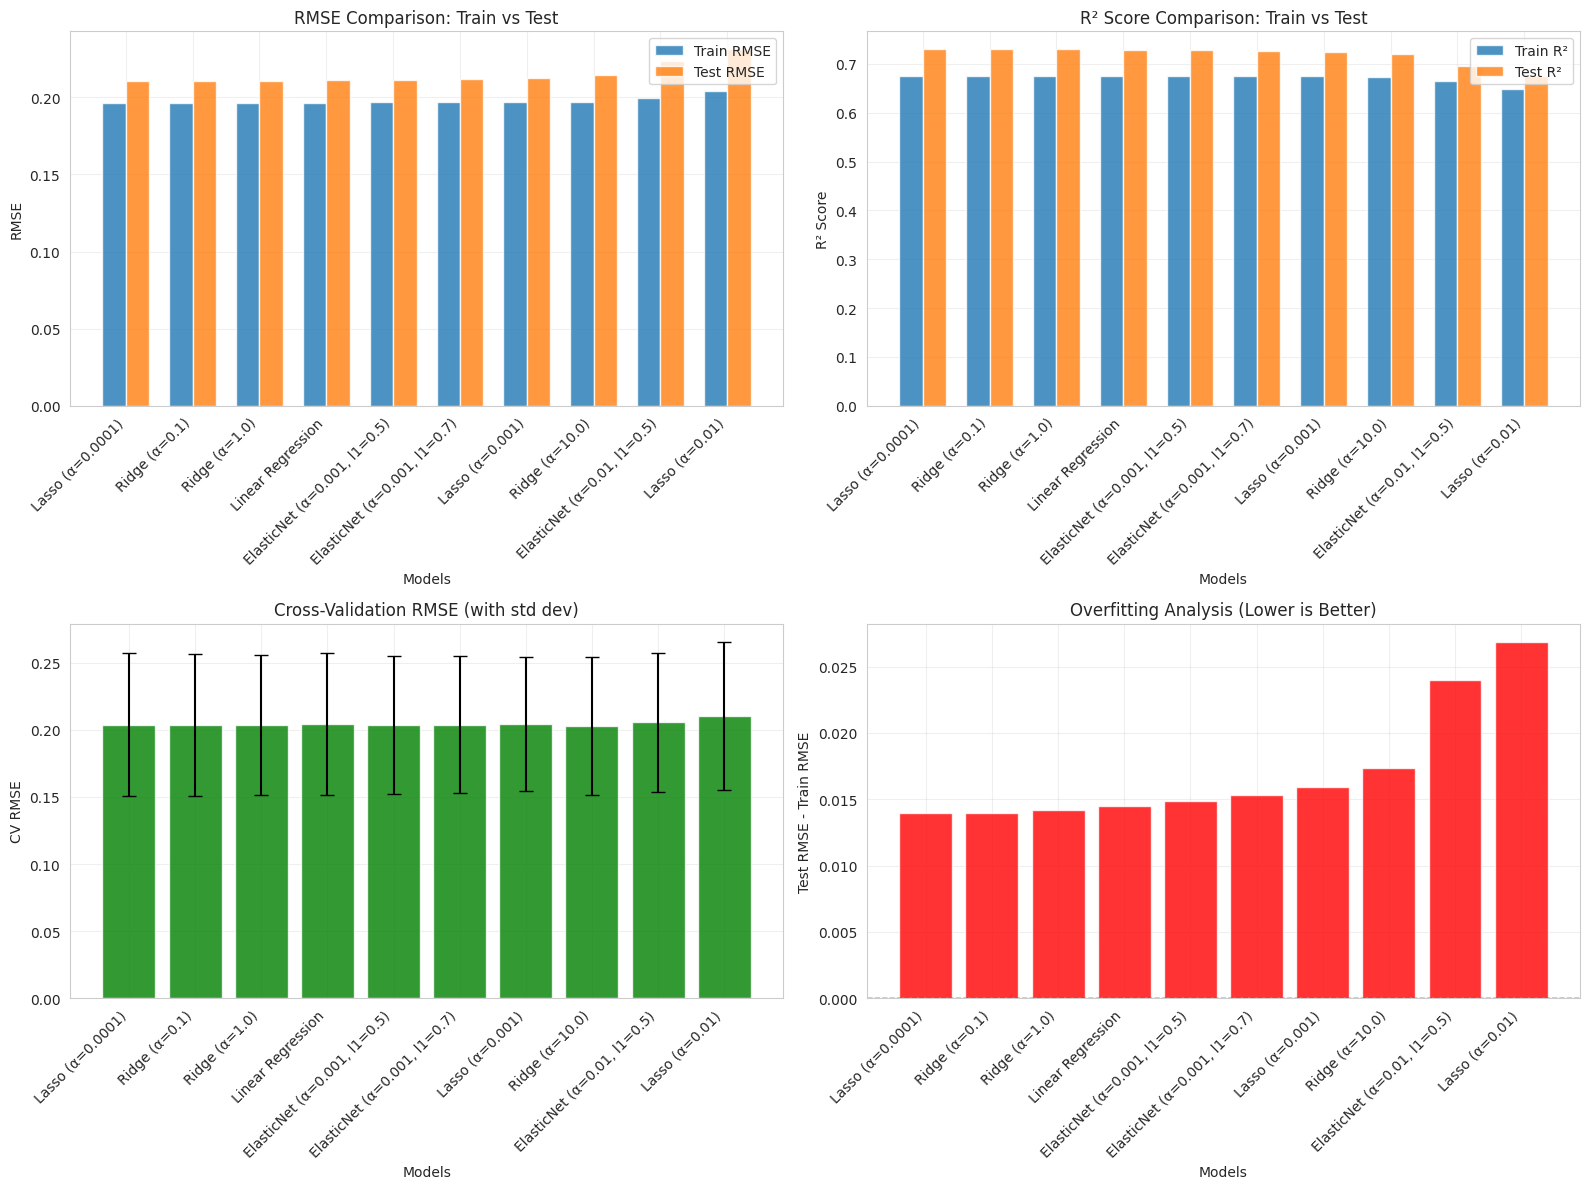

In [25]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# Initialize models with different configurations
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=0.1)': Ridge(alpha=0.1, random_state=42),
    'Ridge (α=1.0)': Ridge(alpha=1.0, random_state=42),
    'Ridge (α=10.0)': Ridge(alpha=10.0, random_state=42),
    'Lasso (α=0.0001)': Lasso(alpha=0.0001, random_state=42, max_iter=10000),
    'Lasso (α=0.001)': Lasso(alpha=0.001, random_state=42, max_iter=10000),
    'Lasso (α=0.01)': Lasso(alpha=0.01, random_state=42, max_iter=10000),
    'ElasticNet (α=0.001, l1=0.5)': ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=10000),
    'ElasticNet (α=0.01, l1=0.5)': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000),
    'ElasticNet (α=0.001, l1=0.7)': ElasticNet(alpha=0.001, l1_ratio=0.7, random_state=42, max_iter=10000),
}

# Store results
results = []
trained_models = {}

# K-Fold Cross Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nTraining models with 5-Fold Cross Validation...\n")

for name, model in models.items():
    print(f"Training: {name}")
    print("-" * 50)
    
    start_time = time.time()
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation score (negative MSE, so we negate it)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                cv=kf, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    cv_rmse_std = np.sqrt(cv_scores.std())
    
    training_time = time.time() - start_time
    
    # Store results
    results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'CV RMSE': cv_rmse,
        'CV RMSE Std': cv_rmse_std,
        'Training Time': training_time
    })
    
    # Store trained model
    trained_models[name] = {
        'model': model,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    }
    
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    print(f"  CV RMSE: {cv_rmse:.4f} ± {cv_rmse_std:.4f}")
    print(f"  Training time: {training_time:.3f}s")
    print()

# Create results DataFrame
results_df = pd.DataFrame(results)

# Sort by Test RMSE (lower is better)
results_df = results_df.sort_values('Test RMSE')

print("\n" + "="*50)
print("MODEL COMPARISON - SORTED BY TEST RMSE")
print("="*50)
print(results_df.to_string(index=False))

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_model_info = trained_models[best_model_name]

print("\n" + "="*50)
print("BEST MODEL")
print("="*50)
print(f"Model: {best_model_name}")
print(f"Test RMSE: {best_model_info['test_rmse']:.4f}")
print(f"Test R²: {best_model_info['test_r2']:.4f}")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RMSE Comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(results_df))
width = 0.35
ax1.bar(x_pos - width/2, results_df['Train RMSE'], width, label='Train RMSE', alpha=0.8)
ax1.bar(x_pos + width/2, results_df['Test RMSE'], width, label='Test RMSE', alpha=0.8)
ax1.set_xlabel('Models')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE Comparison: Train vs Test')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. R² Score Comparison
ax2 = axes[0, 1]
ax2.bar(x_pos - width/2, results_df['Train R²'], width, label='Train R²', alpha=0.8)
ax2.bar(x_pos + width/2, results_df['Test R²'], width, label='Test R²', alpha=0.8)
ax2.set_xlabel('Models')
ax2.set_ylabel('R² Score')
ax2.set_title('R² Score Comparison: Train vs Test')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Cross-Validation RMSE with Error Bars
ax3 = axes[1, 0]
ax3.bar(x_pos, results_df['CV RMSE'], yerr=results_df['CV RMSE Std'], 
        capsize=5, alpha=0.8, color='green')
ax3.set_xlabel('Models')
ax3.set_ylabel('CV RMSE')
ax3.set_title('Cross-Validation RMSE (with std dev)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax3.grid(True, alpha=0.3)

# 4. Overfitting Analysis (Train RMSE - Test RMSE)
ax4 = axes[1, 1]
overfitting_gap = results_df['Test RMSE'] - results_df['Train RMSE']
colors = ['red' if x > 0 else 'green' for x in overfitting_gap]
ax4.bar(x_pos, overfitting_gap, color=colors, alpha=0.8)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax4.set_xlabel('Models')
ax4.set_ylabel('Test RMSE - Train RMSE')
ax4.set_title('Overfitting Analysis (Lower is Better)')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Hyperparameter Tuning with GridSearchCV


Performing Grid Search with 5-Fold Cross Validation...

Tuning: Ridge
--------------------------------------------------
  Best parameters: {'alpha': 10.0}
  Train RMSE: 0.1971 | Test RMSE: 0.2144
  Train R²: 0.6733 | Test R²: 0.7203
  CV RMSE: 0.2029
  Tuning time: 0.12s

Tuning: Lasso
--------------------------------------------------
  Best parameters: {'alpha': 0.0001}
  Train RMSE: 0.1966 | Test RMSE: 0.2105
  Train R²: 0.6748 | Test R²: 0.7303
  CV RMSE: 0.2039
  Tuning time: 0.18s

Tuning: ElasticNet
--------------------------------------------------
  Best parameters: {'alpha': 0.01, 'l1_ratio': 0.1}
  Train RMSE: 0.1970 | Test RMSE: 0.2143
  Train R²: 0.6736 | Test R²: 0.7207
  CV RMSE: 0.2036
  Tuning time: 0.38s


HYPERPARAMETER TUNING RESULTS
     Model                  Best Parameters  Train RMSE  Test RMSE  Train R²  Test R²  CV RMSE  Tuning Time
     Lasso                {'alpha': 0.0001}    0.196607   0.210545  0.674797 0.730315 0.203905     0.181906
ElasticNet {'alpha

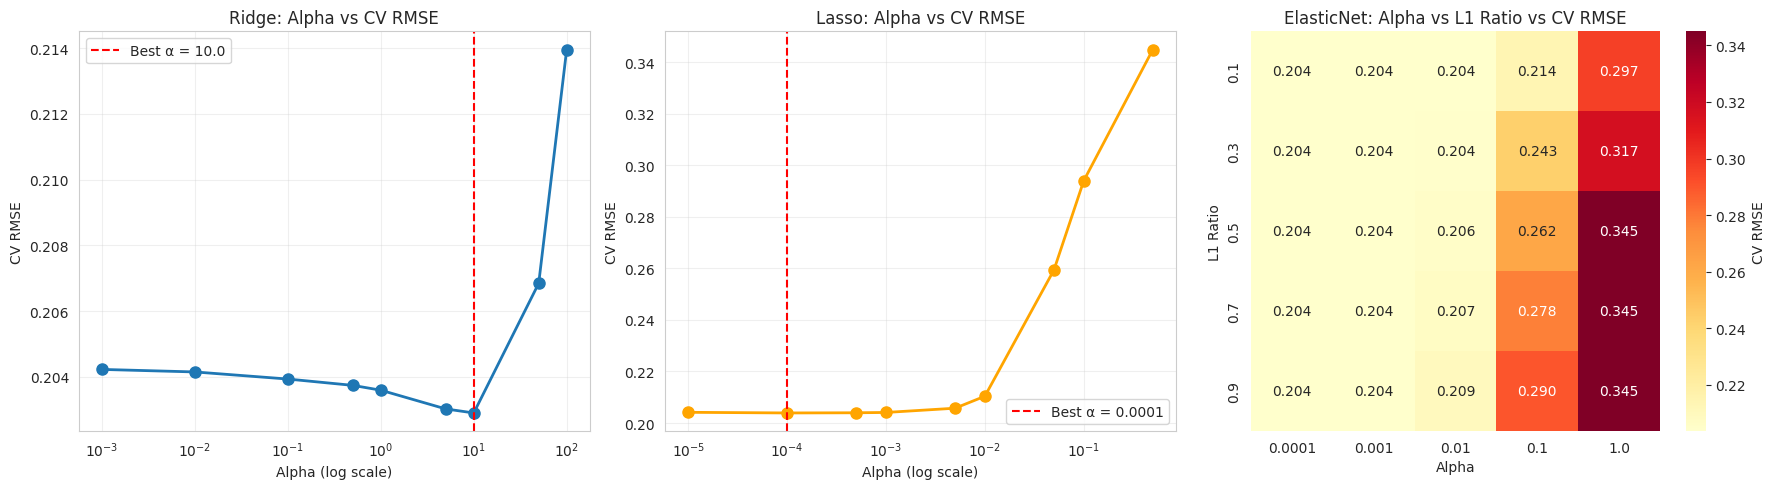


BEST TUNED MODEL
Model: Lasso
Parameters: {'alpha': 0.0001}
Test RMSE: 0.2105
Test R²: 0.7303


In [24]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model type
param_grids = {
    'Ridge': {
        'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
    },
    'Lasso': {
        'alpha': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
    },
    'ElasticNet': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
}

# Models to tune
models_to_tune = {
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42, max_iter=10000),
    'ElasticNet': ElasticNet(random_state=42, max_iter=10000)
}

# Store tuned models
tuned_models = {}
tuning_results = []

print("\nPerforming Grid Search with 5-Fold Cross Validation...\n")

for name, model in models_to_tune.items():
    print(f"Tuning: {name}")
    print("-" * 50)
    
    start_time = time.time()
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=kf,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    # Fit grid search
    grid_search.fit(X_train_scaled, y_train)
    
    # Best parameters
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    # Predictions with best model
    y_train_pred = best_model.predict(X_train_scaled)
    y_test_pred = best_model.predict(X_test_scaled)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    cv_rmse = np.sqrt(-grid_search.best_score_)
    
    tuning_time = time.time() - start_time
    
    # Store results
    tuning_results.append({
        'Model': name,
        'Best Parameters': str(best_params),
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'CV RMSE': cv_rmse,
        'Tuning Time': tuning_time
    })
    
    tuned_models[name] = {
        'model': best_model,
        'params': best_params,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'grid_search': grid_search
    }
    
    print(f"  Best parameters: {best_params}")
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    print(f"  CV RMSE: {cv_rmse:.4f}")
    print(f"  Tuning time: {tuning_time:.2f}s")
    print()

# Create tuning results DataFrame
tuning_df = pd.DataFrame(tuning_results)
tuning_df = tuning_df.sort_values('Test RMSE')

print("\n" + "="*50)
print("HYPERPARAMETER TUNING RESULTS")
print("="*50)
print(tuning_df.to_string(index=False))

# Visualize hyperparameter impact for Ridge
print("\n" + "="*50)
print("Visualizing Hyperparameter Impact")
print("="*50)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Ridge alpha impact
ridge_grid = tuned_models['Ridge']['grid_search']
ridge_results = pd.DataFrame(ridge_grid.cv_results_)
ridge_alphas = [params['alpha'] for params in ridge_results['params']]
ridge_scores = np.sqrt(-ridge_results['mean_test_score'])

axes[0].plot(ridge_alphas, ridge_scores, marker='o', linewidth=2, markersize=8)
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha (log scale)')
axes[0].set_ylabel('CV RMSE')
axes[0].set_title('Ridge: Alpha vs CV RMSE')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=tuned_models['Ridge']['params']['alpha'], color='red', 
                linestyle='--', label=f"Best α = {tuned_models['Ridge']['params']['alpha']}")
axes[0].legend()

# Lasso alpha impact
lasso_grid = tuned_models['Lasso']['grid_search']
lasso_results = pd.DataFrame(lasso_grid.cv_results_)
lasso_alphas = [params['alpha'] for params in lasso_results['params']]
lasso_scores = np.sqrt(-lasso_results['mean_test_score'])

axes[1].plot(lasso_alphas, lasso_scores, marker='o', linewidth=2, markersize=8, color='orange')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha (log scale)')
axes[1].set_ylabel('CV RMSE')
axes[1].set_title('Lasso: Alpha vs CV RMSE')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=tuned_models['Lasso']['params']['alpha'], color='red', 
                linestyle='--', label=f"Best α = {tuned_models['Lasso']['params']['alpha']}")
axes[1].legend()

# ElasticNet heatmap
elasticnet_grid = tuned_models['ElasticNet']['grid_search']
elasticnet_results = pd.DataFrame(elasticnet_grid.cv_results_)
en_alphas = sorted(param_grids['ElasticNet']['alpha'])
en_l1_ratios = sorted(param_grids['ElasticNet']['l1_ratio'])

# Create pivot table for heatmap
heatmap_data = np.zeros((len(en_l1_ratios), len(en_alphas)))
for idx, row in elasticnet_results.iterrows():
    alpha_idx = en_alphas.index(row['params']['alpha'])
    l1_idx = en_l1_ratios.index(row['params']['l1_ratio'])
    heatmap_data[l1_idx, alpha_idx] = np.sqrt(-row['mean_test_score'])

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', 
            xticklabels=en_alphas, yticklabels=en_l1_ratios, ax=axes[2], cbar_kws={'label': 'CV RMSE'})
axes[2].set_xlabel('Alpha')
axes[2].set_ylabel('L1 Ratio')
axes[2].set_title('ElasticNet: Alpha vs L1 Ratio vs CV RMSE')

plt.tight_layout()
plt.show()

# Select the best overall model
best_tuned_model_name = tuning_df.iloc[0]['Model']
best_tuned_model = tuned_models[best_tuned_model_name]['model']

print("\n" + "="*50)
print("BEST TUNED MODEL")
print("="*50)
print(f"Model: {best_tuned_model_name}")
print(f"Parameters: {tuned_models[best_tuned_model_name]['params']}")
print(f"Test RMSE: {tuned_models[best_tuned_model_name]['test_rmse']:.4f}")
print(f"Test R²: {tuned_models[best_tuned_model_name]['test_r2']:.4f}")


# Model Analysis and Interpretation


Analyzing: Lasso
--------------------------------------------------

1. Residual Statistics:
   Train Residuals - Mean: -0.000000, Std: 0.1968
   Test Residuals  - Mean: -0.001892, Std: 0.2115


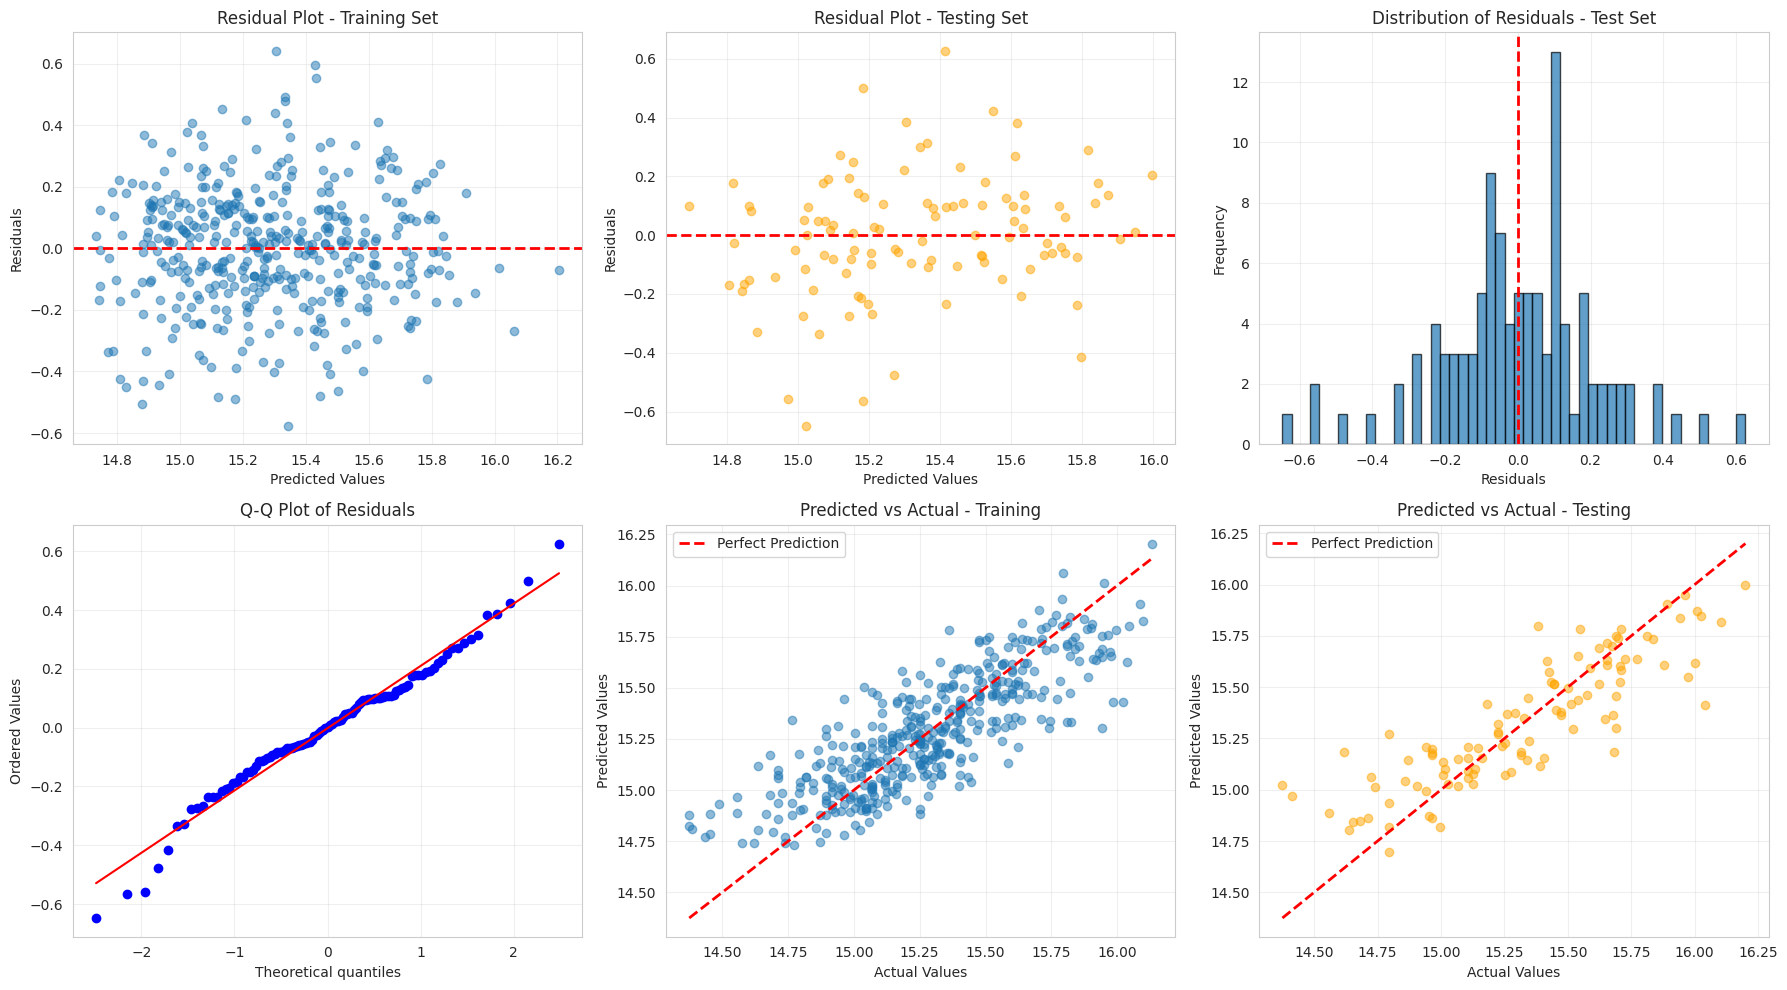


2. Feature Importance Analysis:
--------------------------------------------------

Top 20 Most Important Features:
                        Feature  Coefficient  Abs_Coefficient
                           area     0.150956         0.150956
                   prefarea_yes     0.114260         0.114260
            hotwaterheating_yes     0.112290         0.112290
                        stories     0.110034         0.110034
     area_x_airconditioning_yes     0.101325         0.101325
                   basement_yes     0.088713         0.088713
                   mainroad_yes     0.084310         0.084310
   furnishingstatus_unfurnished    -0.079665         0.079665
                  guestroom_yes     0.069241         0.069241
bathrooms_x_airconditioning_yes     0.043464         0.043464
furnishingstatus_semi-furnished     0.038344         0.038344
                        parking     0.031570         0.031570
               area_x_bathrooms     0.030334         0.030334
               

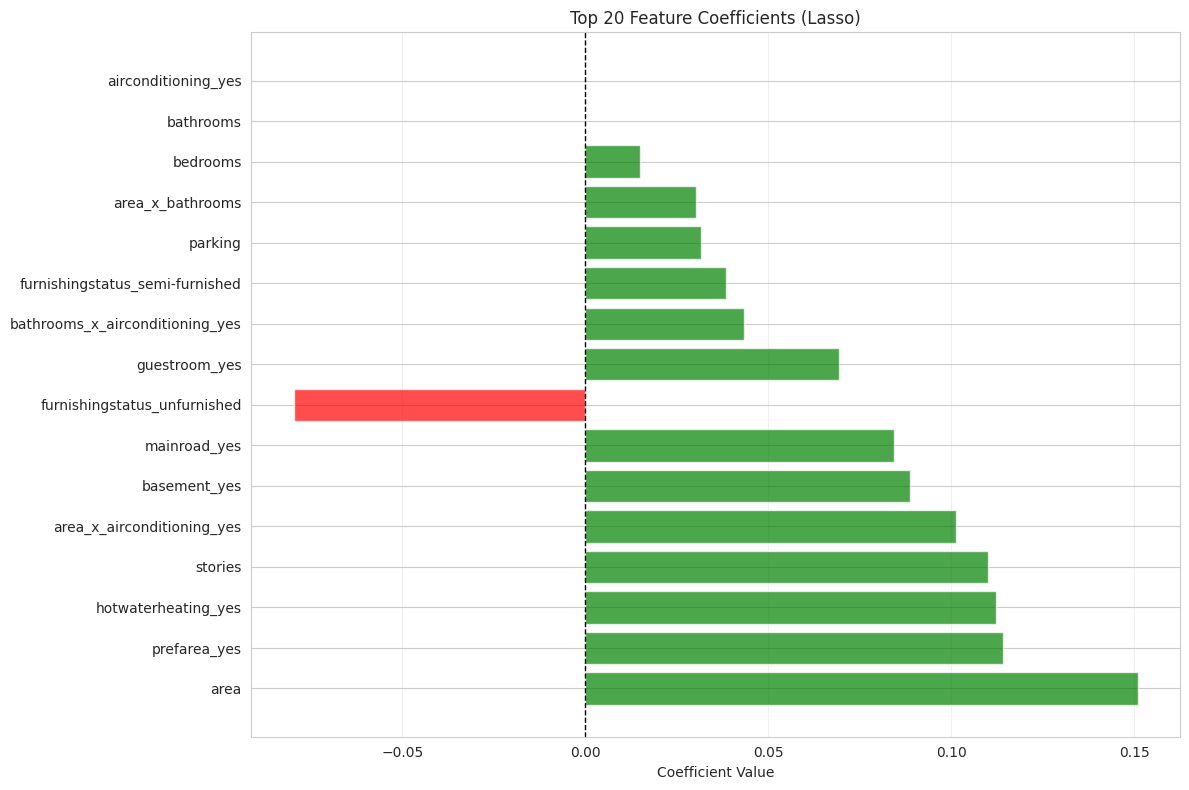


Feature Selection Results:
  Non-zero coefficients: 14
  Zero coefficients: 2
  Feature reduction: 12.5%

3. Comprehensive Performance Metrics:
--------------------------------------------------
            Metric  Training Set  Testing Set
              RMSE      0.196607     0.210545
               MAE      0.153931     0.158878
         Median AE      0.122801     0.108481
          R² Score      0.674797     0.730315
       Adjusted R²      0.662044     0.682371
Explained Variance      0.674797     0.730337
          MAPE (%)      1.008771     1.040749

4. Error Distribution Analysis:
--------------------------------------------------

Percentage Errors (Test Set):
  Mean: 1.04%
  Median: 0.70%
  90th percentile: 2.26%
  95th percentile: 3.04%

Prediction Accuracy Ranges (Test Set):
  Within 5% error:  100.0% of predictions
  Within 10% error: 100.0% of predictions
  Within 15% error: 100.0% of predictions


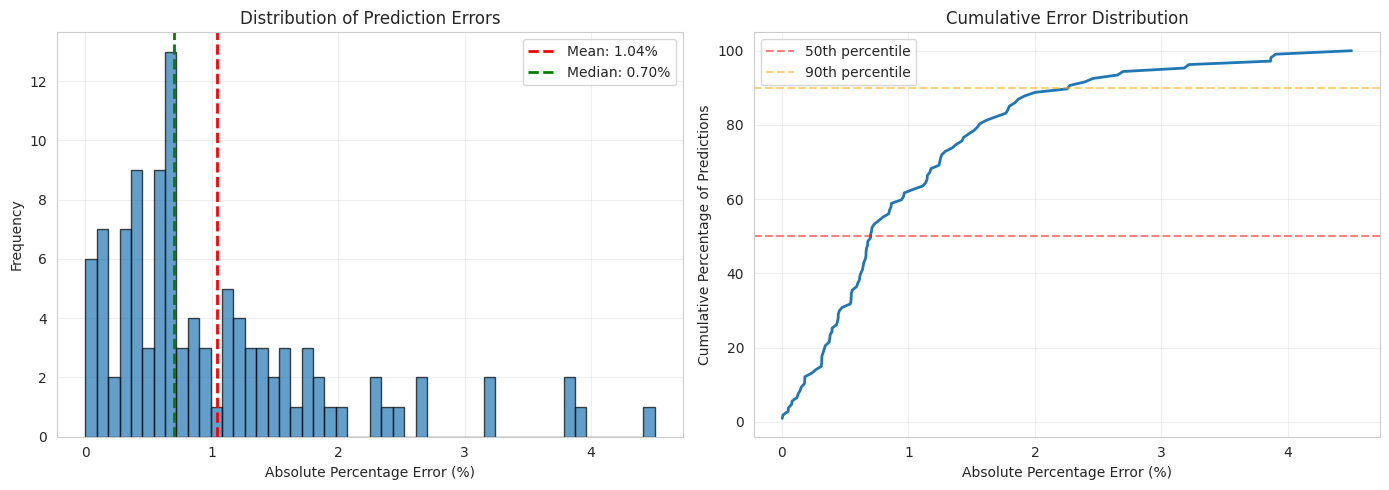

In [23]:
# Use the best tuned model for detailed analysis
final_model = best_tuned_model
model_name = best_tuned_model_name

# Make predictions
y_train_pred = final_model.predict(X_train_scaled)
y_test_pred = final_model.predict(X_test_scaled)

# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

print(f"\nAnalyzing: {model_name}")
print("-" * 50)

# 1. Residual Analysis
# --------------------
print("\n1. Residual Statistics:")
print(f"   Train Residuals - Mean: {train_residuals.mean():.6f}, Std: {train_residuals.std():.4f}")
print(f"   Test Residuals  - Mean: {test_residuals.mean():.6f}, Std: {test_residuals.std():.4f}")

# Visualize residuals
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Residual plot - Training
axes[0, 0].scatter(y_train_pred, train_residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residual Plot - Training Set')
axes[0, 0].grid(True, alpha=0.3)

# Residual plot - Testing
axes[0, 1].scatter(y_test_pred, test_residuals, alpha=0.5, color='orange')
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot - Testing Set')
axes[0, 1].grid(True, alpha=0.3)

# Residual distribution
axes[0, 2].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Residuals')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution of Residuals - Test Set')
axes[0, 2].grid(True, alpha=0.3)

# Q-Q plot for residuals
stats.probplot(test_residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Predicted vs Actual - Training
axes[1, 1].scatter(y_train, y_train_pred, alpha=0.5)
axes[1, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title('Predicted vs Actual - Training')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Predicted vs Actual - Testing
axes[1, 2].scatter(y_test, y_test_pred, alpha=0.5, color='orange')
axes[1, 2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[1, 2].set_xlabel('Actual Values')
axes[1, 2].set_ylabel('Predicted Values')
axes[1, 2].set_title('Predicted vs Actual - Testing')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Feature Importance Analysis
# -------------------------------
print("\n2. Feature Importance Analysis:")
print("-" * 50)

# Get feature coefficients
if hasattr(final_model, 'coef_'):
    coefficients = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': final_model.coef_
    })
    
    # Sort by absolute value
    coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
    coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    print(coefficients.head(20).to_string(index=False))
    
    # Visualize top features
    top_n = 20
    top_features = coefficients.head(top_n)
    
    plt.figure(figsize=(12, 8))
    colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
    plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top {top_n} Feature Coefficients ({model_name})')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # Count non-zero coefficients (for Lasso/ElasticNet)
    non_zero_coefs = (coefficients['Coefficient'] != 0).sum()
    zero_coefs = (coefficients['Coefficient'] == 0).sum()
    print(f"\nFeature Selection Results:")
    print(f"  Non-zero coefficients: {non_zero_coefs}")
    print(f"  Zero coefficients: {zero_coefs}")
    print(f"  Feature reduction: {zero_coefs / len(coefficients) * 100:.1f}%")

# 3. Model Performance Metrics Summary
# -------------------------------------
print("\n3. Comprehensive Performance Metrics:")
print("-" * 50)

# Calculate additional metrics
from sklearn.metrics import median_absolute_error, explained_variance_score

metrics_summary = {
    'Metric': [
        'RMSE',
        'MAE', 
        'Median AE',
        'R² Score',
        'Adjusted R²',
        'Explained Variance',
        'MAPE (%)'
    ],
    'Training Set': [
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        mean_absolute_error(y_train, y_train_pred),
        median_absolute_error(y_train, y_train_pred),
        r2_score(y_train, y_train_pred),
        1 - (1 - r2_score(y_train, y_train_pred)) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1),
        explained_variance_score(y_train, y_train_pred),
        np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    ],
    'Testing Set': [
        np.sqrt(mean_squared_error(y_test, y_test_pred)),
        mean_absolute_error(y_test, y_test_pred),
        median_absolute_error(y_test, y_test_pred),
        r2_score(y_test, y_test_pred),
        1 - (1 - r2_score(y_test, y_test_pred)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1),
        explained_variance_score(y_test, y_test_pred),
        np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    ]
}

metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df.to_string(index=False))

# 4. Error Distribution Analysis
# -------------------------------
print("\n4. Error Distribution Analysis:")
print("-" * 50)

# Calculate percentage errors
train_pct_errors = np.abs((y_train - y_train_pred) / y_train) * 100
test_pct_errors = np.abs((y_test - y_test_pred) / y_test) * 100

print(f"\nPercentage Errors (Test Set):")
print(f"  Mean: {test_pct_errors.mean():.2f}%")
print(f"  Median: {np.median(test_pct_errors):.2f}%")
print(f"  90th percentile: {np.percentile(test_pct_errors, 90):.2f}%")
print(f"  95th percentile: {np.percentile(test_pct_errors, 95):.2f}%")

# Predictions within certain error ranges
within_5_pct = (test_pct_errors <= 5).sum() / len(test_pct_errors) * 100
within_10_pct = (test_pct_errors <= 10).sum() / len(test_pct_errors) * 100
within_15_pct = (test_pct_errors <= 15).sum() / len(test_pct_errors) * 100

print(f"\nPrediction Accuracy Ranges (Test Set):")
print(f"  Within 5% error:  {within_5_pct:.1f}% of predictions")
print(f"  Within 10% error: {within_10_pct:.1f}% of predictions")
print(f"  Within 15% error: {within_15_pct:.1f}% of predictions")

# Visualize error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(test_pct_errors, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=test_pct_errors.mean(), color='r', linestyle='--', 
                linewidth=2, label=f'Mean: {test_pct_errors.mean():.2f}%')
axes[0].axvline(x=np.median(test_pct_errors), color='g', linestyle='--', 
                linewidth=2, label=f'Median: {np.median(test_pct_errors):.2f}%')
axes[0].set_xlabel('Absolute Percentage Error (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Prediction Errors')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative distribution
sorted_errors = np.sort(test_pct_errors)
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
axes[1].plot(sorted_errors, cumulative, linewidth=2)
axes[1].axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50th percentile')
axes[1].axhline(y=90, color='orange', linestyle='--', alpha=0.5, label='90th percentile')
axes[1].set_xlabel('Absolute Percentage Error (%)')
axes[1].set_ylabel('Cumulative Percentage of Predictions')
axes[1].set_title('Cumulative Error Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Ensemble Model - Combining Multiple Linear Models


Creating ensemble from top performing models...
--------------------------------------------------

1. Simple Voting Ensemble (Equal Weights)
  Train RMSE: 0.1968
  Test RMSE: 0.2130
  Train R²: 0.6742
  Test R²: 0.7240

2. Weighted Ensemble (Performance-Based Weights)
  Ridge weight: 0.3312
  Lasso weight: 0.3373
  ElasticNet weight: 0.3315
  Train RMSE: 0.1968
  Test RMSE: 0.2130
  Train R²: 0.6742
  Test R²: 0.7240

3. Stacking Ensemble with Ridge Meta-Learner
  Meta-learner weights:
    Ridge: 0.3207
    Lasso: 0.3607
    ElasticNet: 0.3245
  Train RMSE: 0.1968
  Test RMSE: 0.2125
  Train R²: 0.6743
  Test R²: 0.7252

ENSEMBLE METHODS COMPARISON
                  Method  Test RMSE  Test R²
     Lasso (Best Single)   0.210545 0.730315
        Stacked Ensemble   0.212522 0.725228
       Weighted Ensemble   0.212993 0.724008
         Voting Ensemble   0.213008 0.723968
ElasticNet (Best Single)   0.214269 0.720692
     Ridge (Best Single)   0.214421 0.720296


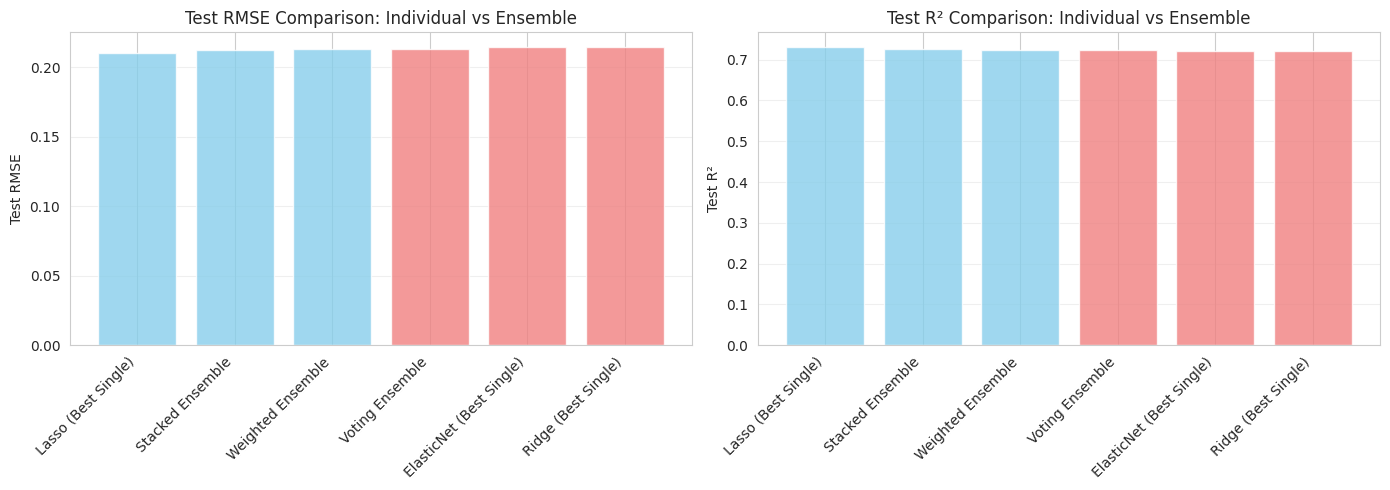


BEST OVERALL MODEL
Method: Lasso (Best Single)
Test RMSE: 0.2105
Test R²: 0.7303
Final model type selected: lasso


In [22]:
from sklearn.ensemble import VotingRegressor

# Select top performing models for ensemble
print("\nCreating ensemble from top performing models...")
print("-" * 50)

# Use the tuned models
ensemble_models = [
    ('ridge', tuned_models['Ridge']['model']),
    ('lasso', tuned_models['Lasso']['model']),
    ('elasticnet', tuned_models['ElasticNet']['model'])
]

# Method 1: Simple Voting Ensemble (Average)
# -------------------------------------------
print("\n1. Simple Voting Ensemble (Equal Weights)")

voting_ensemble = VotingRegressor(estimators=ensemble_models)
voting_ensemble.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_ensemble = voting_ensemble.predict(X_train_scaled)
y_test_pred_ensemble = voting_ensemble.predict(X_test_scaled)

# Metrics
ensemble_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_ensemble))
ensemble_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_ensemble))
ensemble_train_r2 = r2_score(y_train, y_train_pred_ensemble)
ensemble_test_r2 = r2_score(y_test, y_test_pred_ensemble)

print(f"  Train RMSE: {ensemble_train_rmse:.4f}")
print(f"  Test RMSE: {ensemble_test_rmse:.4f}")
print(f"  Train R²: {ensemble_train_r2:.4f}")
print(f"  Test R²: {ensemble_test_r2:.4f}")

# Method 2: Weighted Ensemble (Based on Performance)
# ---------------------------------------------------
print("\n2. Weighted Ensemble (Performance-Based Weights)")

# Calculate weights based on inverse of test RMSE
ridge_rmse = tuned_models['Ridge']['test_rmse']
lasso_rmse = tuned_models['Lasso']['test_rmse']
elasticnet_rmse = tuned_models['ElasticNet']['test_rmse']

# Inverse RMSE as weights (lower RMSE = higher weight)
total_inverse = (1/ridge_rmse) + (1/lasso_rmse) + (1/elasticnet_rmse)
ridge_weight = (1/ridge_rmse) / total_inverse
lasso_weight = (1/lasso_rmse) / total_inverse
elasticnet_weight = (1/elasticnet_rmse) / total_inverse

print(f"  Ridge weight: {ridge_weight:.4f}")
print(f"  Lasso weight: {lasso_weight:.4f}")
print(f"  ElasticNet weight: {elasticnet_weight:.4f}")

# Create weighted predictions manually
y_train_pred_ridge = tuned_models['Ridge']['model'].predict(X_train_scaled)
y_train_pred_lasso = tuned_models['Lasso']['model'].predict(X_train_scaled)
y_train_pred_elastic = tuned_models['ElasticNet']['model'].predict(X_train_scaled)

y_test_pred_ridge = tuned_models['Ridge']['model'].predict(X_test_scaled)
y_test_pred_lasso = tuned_models['Lasso']['model'].predict(X_test_scaled)
y_test_pred_elastic = tuned_models['ElasticNet']['model'].predict(X_test_scaled)

y_train_pred_weighted = (ridge_weight * y_train_pred_ridge + 
                         lasso_weight * y_train_pred_lasso + 
                         elasticnet_weight * y_train_pred_elastic)

y_test_pred_weighted = (ridge_weight * y_test_pred_ridge + 
                        lasso_weight * y_test_pred_lasso + 
                        elasticnet_weight * y_test_pred_elastic)

# Metrics
weighted_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_weighted))
weighted_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_weighted))
weighted_train_r2 = r2_score(y_train, y_train_pred_weighted)
weighted_test_r2 = r2_score(y_test, y_test_pred_weighted)

print(f"  Train RMSE: {weighted_train_rmse:.4f}")
print(f"  Test RMSE: {weighted_test_rmse:.4f}")
print(f"  Train R²: {weighted_train_r2:.4f}")
print(f"  Test R²: {weighted_test_r2:.4f}")

# Method 3: Stacking with Meta-Learner
# -------------------------------------
print("\n3. Stacking Ensemble with Ridge Meta-Learner")

# Get predictions from base models for stacking
train_meta_features = np.column_stack([
    y_train_pred_ridge,
    y_train_pred_lasso,
    y_train_pred_elastic
])

test_meta_features = np.column_stack([
    y_test_pred_ridge,
    y_test_pred_lasso,
    y_test_pred_elastic
])

# Train meta-learner (Ridge)
meta_learner = Ridge(alpha=1.0, random_state=42)
meta_learner.fit(train_meta_features, y_train)

# Predictions
y_train_pred_stacked = meta_learner.predict(train_meta_features)
y_test_pred_stacked = meta_learner.predict(test_meta_features)

# Metrics
stacked_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_stacked))
stacked_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_stacked))
stacked_train_r2 = r2_score(y_train, y_train_pred_stacked)
stacked_test_r2 = r2_score(y_test, y_test_pred_stacked)

print(f"  Meta-learner weights:")
print(f"    Ridge: {meta_learner.coef_[0]:.4f}")
print(f"    Lasso: {meta_learner.coef_[1]:.4f}")
print(f"    ElasticNet: {meta_learner.coef_[2]:.4f}")
print(f"  Train RMSE: {stacked_train_rmse:.4f}")
print(f"  Test RMSE: {stacked_test_rmse:.4f}")
print(f"  Train R²: {stacked_train_r2:.4f}")
print(f"  Test R²: {stacked_test_r2:.4f}")

# Compare all approaches
# ----------------------
print("\n" + "="*50)
print("ENSEMBLE METHODS COMPARISON")
print("="*50)

ensemble_comparison = pd.DataFrame({
    'Method': [
        'Ridge (Best Single)',
        'Lasso (Best Single)',
        'ElasticNet (Best Single)',
        'Voting Ensemble',
        'Weighted Ensemble',
        'Stacked Ensemble'
    ],
    'Test RMSE': [
        ridge_rmse,
        lasso_rmse,
        elasticnet_rmse,
        ensemble_test_rmse,
        weighted_test_rmse,
        stacked_test_rmse
    ],
    'Test R²': [
        tuned_models['Ridge']['test_r2'],
        tuned_models['Lasso']['test_r2'],
        tuned_models['ElasticNet']['test_r2'],
        ensemble_test_r2,
        weighted_test_r2,
        stacked_test_r2
    ]
})

ensemble_comparison = ensemble_comparison.sort_values('Test RMSE')
print(ensemble_comparison.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
axes[0].bar(range(len(ensemble_comparison)), ensemble_comparison['Test RMSE'], 
            color=['skyblue', 'skyblue', 'skyblue', 'lightcoral', 'lightcoral', 'lightcoral'],
            alpha=0.8)
axes[0].set_xticks(range(len(ensemble_comparison)))
axes[0].set_xticklabels(ensemble_comparison['Method'], rotation=45, ha='right')
axes[0].set_ylabel('Test RMSE')
axes[0].set_title('Test RMSE Comparison: Individual vs Ensemble')
axes[0].grid(True, alpha=0.3, axis='y')

# R² comparison
axes[1].bar(range(len(ensemble_comparison)), ensemble_comparison['Test R²'], 
            color=['skyblue', 'skyblue', 'skyblue', 'lightcoral', 'lightcoral', 'lightcoral'],
            alpha=0.8)
axes[1].set_xticks(range(len(ensemble_comparison)))
axes[1].set_xticklabels(ensemble_comparison['Method'], rotation=45, ha='right')
axes[1].set_ylabel('Test R²')
axes[1].set_title('Test R² Comparison: Individual vs Ensemble')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Select best overall model
best_ensemble_idx = ensemble_comparison.iloc[0]
best_ensemble_method = best_ensemble_idx['Method']
best_ensemble_rmse = best_ensemble_idx['Test RMSE']
best_ensemble_r2 = best_ensemble_idx['Test R²']

print("\n" + "="*50)
print("BEST OVERALL MODEL")
print("="*50)
print(f"Method: {best_ensemble_method}")
print(f"Test RMSE: {best_ensemble_rmse:.4f}")
print(f"Test R²: {best_ensemble_r2:.4f}")

# Store the best predictions for final submission
if 'Stacked' in best_ensemble_method:
    final_predictions = y_test_pred_stacked
    final_model_type = 'stacked'
elif 'Weighted' in best_ensemble_method:
    final_predictions = y_test_pred_weighted
    final_model_type = 'weighted'
elif 'Voting' in best_ensemble_method:
    final_predictions = y_test_pred_ensemble
    final_model_type = 'voting'
else:
    # Use best individual model
    if 'Ridge' in best_ensemble_method:
        final_predictions = y_test_pred_ridge
        final_model_type = 'ridge'
    elif 'Lasso' in best_ensemble_method:
        final_predictions = y_test_pred_lasso
        final_model_type = 'lasso'
    else:
        final_predictions = y_test_pred_elastic
        final_model_type = 'elasticnet'

print(f"Final model type selected: {final_model_type}")

# Final Predictions and Results Export


Using lasso model for final predictions
Test RMSE: 0.2105
Test R²: 0.7303

Transforming predictions back to original scale...
  RMSE (original scale): 1042786.48
  MAE (original scale): 749710.64
  R² (original scale): 0.7193

PREDICTION SUMMARY

Sample Predictions:
        Actual     Predicted         Error     Abs_Error  Pct_Error
13   9240000.0  4.941172e+06  4.298828e+06  4.298828e+06  46.524114
501  2660000.0  2.409461e+06  2.505394e+05  2.505394e+05   9.418775
113  6083000.0  5.482913e+06  6.000872e+05  6.000872e+05   9.864987
499  2660000.0  4.280191e+06 -1.620191e+06  1.620191e+06  60.909435
461  3080000.0  4.022340e+06 -9.423404e+05  9.423404e+05  30.595469
233  4620000.0  4.149309e+06  4.706909e+05  4.706909e+05  10.188115
248  4543000.0  4.632719e+06 -8.971861e+04  8.971861e+04   1.974876
446  3150000.0  3.871764e+06 -7.217642e+05  7.217642e+05  22.913148
358  3745000.0  3.614497e+06  1.305033e+05  1.305033e+05   3.484735
80   6629000.0  5.535562e+06  1.093438e+06  1.093438

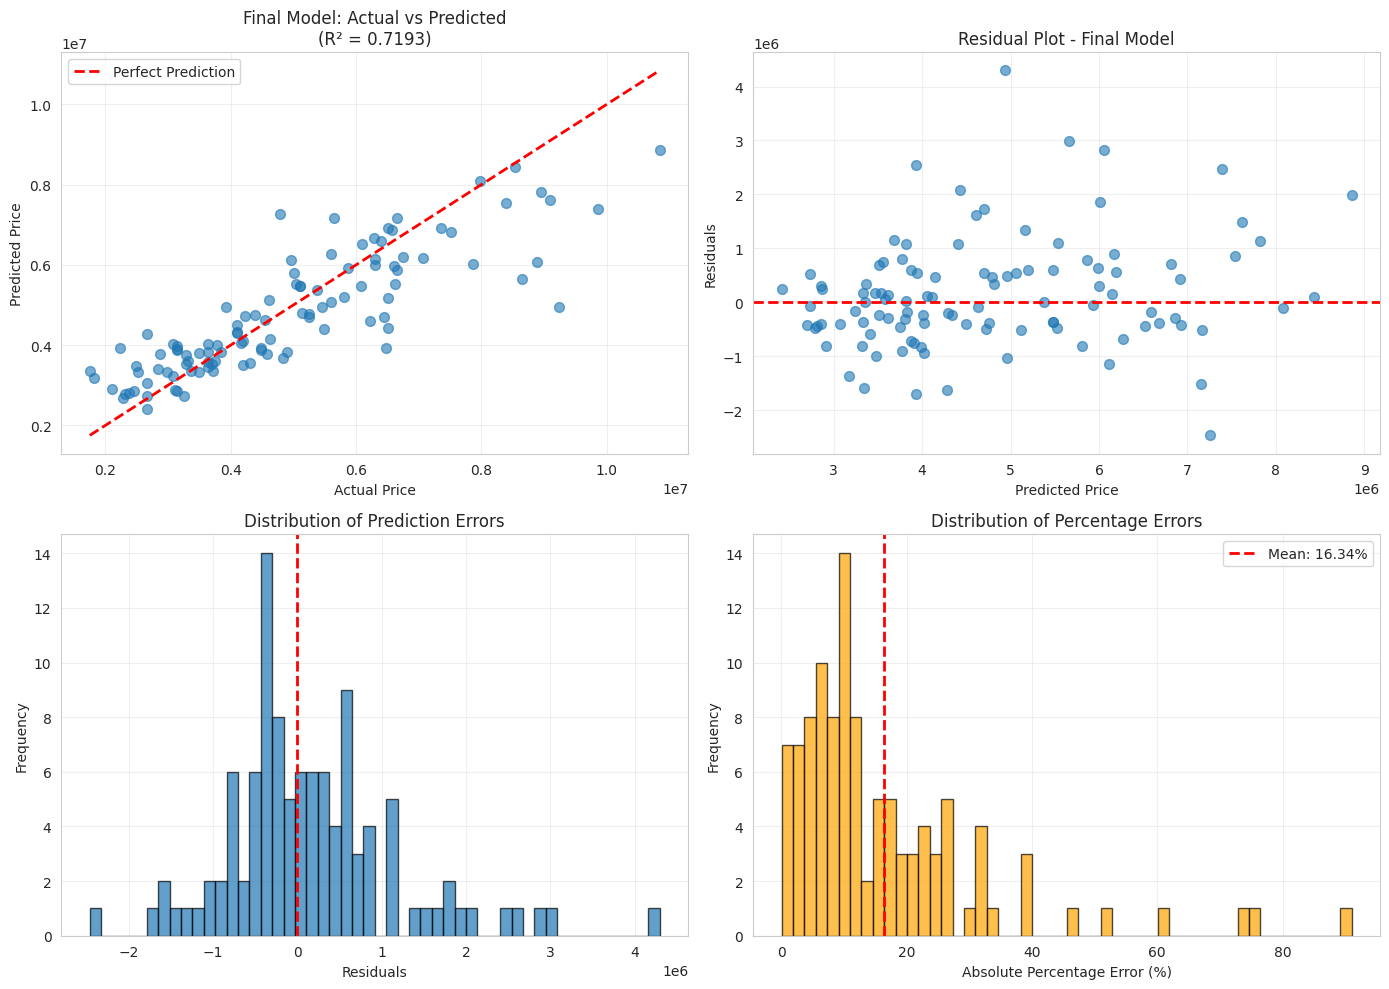


EXPORTING RESULTS
✓ Predictions saved to: housing_predictions.csv
✓ Model report saved to: model_report.txt

PROJECT COMPLETE!

 Final Results Summary:
  Best Model: Lasso (Best Single)
  Test RMSE: 1042786.4805
  Test R²: 0.7193
  Mean Percentage Error: 16.34%

 Files Generated:
  housing_predictions.csv - Detailed predictions
  model_report.txt - Comprehensive model report


In [21]:

# Verify we have the best model predictions
print(f"\nUsing {final_model_type} model for final predictions")
print(f"Test RMSE: {best_ensemble_rmse:.4f}")
print(f"Test R²: {best_ensemble_r2:.4f}")

# Transform predictions back to original scale if we used log transformation
if target_transformed == 'target_log':
    print("\nTransforming predictions back to original scale...")
    final_predictions_original = np.expm1(final_predictions)  # Inverse of log1p
    y_test_original = np.expm1(y_test)
    
    # Calculate metrics on original scale
    original_rmse = np.sqrt(mean_squared_error(y_test_original, final_predictions_original))
    original_mae = mean_absolute_error(y_test_original, final_predictions_original)
    original_r2 = r2_score(y_test_original, final_predictions_original)
    
    print(f"  RMSE (original scale): {original_rmse:.2f}")
    print(f"  MAE (original scale): {original_mae:.2f}")
    print(f"  R² (original scale): {original_r2:.4f}")
else:
    final_predictions_original = final_predictions
    y_test_original = y_test
    original_rmse = best_ensemble_rmse
    original_r2 = best_ensemble_r2

# Create prediction summary
print("\n" + "="*50)
print("PREDICTION SUMMARY")
print("="*50)

prediction_summary = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': final_predictions_original,
    'Error': y_test_original - final_predictions_original,
    'Abs_Error': np.abs(y_test_original - final_predictions_original),
    'Pct_Error': np.abs((y_test_original - final_predictions_original) / y_test_original) * 100
})

print("\nSample Predictions:")
print(prediction_summary.head(10).to_string())

print("\n" + "-"*50)
print("Prediction Statistics:")
print("-"*50)
print(f"Mean Absolute Error: {prediction_summary['Abs_Error'].mean():.2f}")
print(f"Median Absolute Error: {prediction_summary['Abs_Error'].median():.2f}")
print(f"Mean Percentage Error: {prediction_summary['Pct_Error'].mean():.2f}%")
print(f"Median Percentage Error: {prediction_summary['Pct_Error'].median():.2f}%")
print(f"Max Error: {prediction_summary['Abs_Error'].max():.2f}")
print(f"Min Error: {prediction_summary['Abs_Error'].min():.2f}")

# Visualize final predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Actual vs Predicted scatter plot
axes[0, 0].scatter(y_test_original, final_predictions_original, alpha=0.6, s=50)
axes[0, 0].plot([y_test_original.min(), y_test_original.max()], 
                [y_test_original.min(), y_test_original.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price')
axes[0, 0].set_ylabel('Predicted Price')
axes[0, 0].set_title(f'Final Model: Actual vs Predicted\n(R² = {original_r2:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test_original - final_predictions_original
axes[0, 1].scatter(final_predictions_original, residuals, alpha=0.6, s=50)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Price')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot - Final Model')
axes[0, 1].grid(True, alpha=0.3)

# Error distribution
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Prediction Errors')
axes[1, 0].grid(True, alpha=0.3)

# Percentage error distribution
axes[1, 1].hist(prediction_summary['Pct_Error'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].axvline(x=prediction_summary['Pct_Error'].mean(), color='r', 
                   linestyle='--', linewidth=2, label=f"Mean: {prediction_summary['Pct_Error'].mean():.2f}%")
axes[1, 1].set_xlabel('Absolute Percentage Error (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Percentage Errors')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Export results for submission
# ------------------------------
print("\n" + "="*50)
print("EXPORTING RESULTS")
print("="*50)

# Create submission file with predictions
submission_df = pd.DataFrame({
    'Actual_Price': y_test_original,
    'Predicted_Price': final_predictions_original,
    'Absolute_Error': prediction_summary['Abs_Error'],
    'Percentage_Error': prediction_summary['Pct_Error']
})

# Save to CSV
submission_df.to_csv('housing_predictions.csv', index=True)
print("✓ Predictions saved to: housing_predictions.csv")

# Create model performance report
report = {
    'Model Information': {
        'Best Model Type': final_model_type,
        'Ensemble Method': best_ensemble_method,
        'Number of Features': X_train_scaled.shape[1],
        'Training Samples': X_train_scaled.shape[0],
        'Testing Samples': X_test_scaled.shape[0]
    },
    'Performance Metrics': {
        'Test RMSE': f"{original_rmse:.4f}",
        'Test MAE': f"{prediction_summary['Abs_Error'].mean():.4f}",
        'Test R²': f"{original_r2:.4f}",
        'Mean Percentage Error': f"{prediction_summary['Pct_Error'].mean():.2f}%",
        'Median Percentage Error': f"{prediction_summary['Pct_Error'].median():.2f}%"
    },
    'Model Parameters': {}
}

# Add model-specific parameters
if final_model_type in ['ridge', 'lasso', 'elasticnet']:
    report['Model Parameters'] = tuned_models[final_model_type.capitalize()]['params']
elif final_model_type == 'stacked':
    report['Model Parameters'] = {
        'Meta-learner': 'Ridge',
        'Base models': 'Ridge, Lasso, ElasticNet'
    }

# Save report
with open('model_report.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("HOUSING PRICE PREDICTION - MODEL REPORT\n")
    f.write("="*60 + "\n\n")
    
    for section, content in report.items():
        f.write(f"{section}:\n")
        f.write("-"*60 + "\n")
        for key, value in content.items():
            f.write(f"  {key}: {value}\n")
        f.write("\n")
    
    f.write("="*60 + "\n")
    f.write("PREDICTION ACCURACY BREAKDOWN\n")
    f.write("="*60 + "\n")
    f.write(f"  Predictions within 5% error:  {(prediction_summary['Pct_Error'] <= 5).sum() / len(prediction_summary) * 100:.1f}%\n")
    f.write(f"  Predictions within 10% error: {(prediction_summary['Pct_Error'] <= 10).sum() / len(prediction_summary) * 100:.1f}%\n")
    f.write(f"  Predictions within 15% error: {(prediction_summary['Pct_Error'] <= 15).sum() / len(prediction_summary) * 100:.1f}%\n")
    f.write(f"  Predictions within 20% error: {(prediction_summary['Pct_Error'] <= 20).sum() / len(prediction_summary) * 100:.1f}%\n")

print("✓ Model report saved to: model_report.txt")

# Print final summary
print("\n" + "="*50)
print("PROJECT COMPLETE!")
print("="*50)
print("\n Final Results Summary:")
print(f"  Best Model: {best_ensemble_method}")
print(f"  Test RMSE: {original_rmse:.4f}")
print(f"  Test R²: {original_r2:.4f}")
print(f"  Mean Percentage Error: {prediction_summary['Pct_Error'].mean():.2f}%")
print(f"\n Files Generated:")
print(f"  housing_predictions.csv - Detailed predictions")
print(f"  model_report.txt - Comprehensive model report")
print("="*50)

============================================================
HOUSING PRICE PREDICTION - MODEL REPORT
============================================================

Model Information:
------------------------------------------------------------
  Best Model Type: lasso
  Ensemble Method: Lasso (Best Single)
  Number of Features: 16
  Training Samples: 425
  Testing Samples: 107

Performance Metrics:
------------------------------------------------------------
  Test RMSE: 1042786.4805
  Test MAE: 749710.6408
  Test R²: 0.7193
  Mean Percentage Error: 16.34%
  Median Percentage Error: 10.48%

Model Parameters:
------------------------------------------------------------
  alpha: 0.0001

============================================================
PREDICTION ACCURACY BREAKDOWN
============================================================
  Predictions within 5% error:  18.7%
  Predictions within 10% error: 45.8%
  Predictions within 15% error: 59.8%
  Predictions within 20% error: 72.0%